# Prediction of financial actives prices

In this problem we will face the problem of Financial Actives prediction. So this problem can be resolved as regression problem of 2 targets: 'event_real_min' and 'event_real_max'.

We will split the analysis into following parts:

- Exploratory analysis: observation of the raw data, check types, check presence of NaNs.
- Visualisation: PairPlot to show the presence or absence of correlation among numerical parameters, Time Series to show evolution of prices and DistPlot to show the difference between the distributions of user answers and real values.
- Feature Engineering: creation of new features (hope that they will help us in prediction), OneHotEncoding of categorical variable 'ticker'.
- Prediction for each target (event_real_min, event_real_max) using RandomForestRegressor as one of the most robust model which can give high performance with few pretreated data with lots of categorical columns. It is very flexible and don't require heavy computational resources. As the metric we will use MSE.
- Conclusion + improvement suggestions.


In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt

import scipy.stats as stats
import seaborn as sns
from collections import Counter
import re
import glob
import datetime
from datetime import datetime
from dateutil import parser
from pprint import pprint

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import precision_recall_curve, classification_report, roc_curve, log_loss, accuracy_score

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics

import math
from mpl_toolkits.mplot3d import Axes3D

from sklearn.utils import resample

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import os 

C:\Users\mvideo\Anaconda3-1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [154]:
import pylab as pl
from sklearn.preprocessing import OneHotEncoder

In [188]:
def model_perfo(ytest, preds):
    # estimate model performance
    # calculate MSE
    print('MSE: ', mean_squared_error(ytest, preds))

    # plot preds and real values
    plt.figure(figsize=(5,5))
    #plt.plot(y_test, predicted)
    plt.scatter(ytest, preds)
    plt.xlabel('y_test')
    plt.ylabel('predicted')
    plt.show()

def validation_models(models,X,y):
    model_names,means,stds = [],[],[]
    for name, model in models:
         #cross validation among models, score based on accuracy
         cv_results = cross_val_score(model,X,y, scoring='accuracy', cv=kfold )
         #print("\n"+name)
         model_names.append(name)
         #print("Result: "+str(cv_results))
         #print("Mean: " + str(cv_results.mean()))
         #print("Standard Deviation: " + str(cv_results.std()))
         means.append(cv_results.mean())
         stds.append(cv_results.std())
    return model_names,means,stds

def apply_models(models,X_train, X_test, y_train, y_test):
    for name, model in models:
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        print(name+' confusion matrix')
        print(pd.crosstab(y_test, preds, rownames=['Real'], colnames=['Predicted']))
        print('--------------------------------------------------------------------')
    return models

# Plot accuracy
def plot_accuracy(models,means,stds):
    x_loc = np.arange(len(models))
    width = 0.5
    fig = plt.figure(figsize=(10,6))
    models_graph = plt.bar(x_loc, means, width, yerr=stds)
    plt.ylabel('Accuracy')
    plt.title('Scores by models')
    plt.xticks(x_loc, model_names,rotation=90) # models name on x-axis

    #add valve on the top of every bar
    def addLabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '{0:.3f}'.format(height), ha='center',
            va='bottom')

    addLabel(models_graph)

    plt.show()

def ROC_curve(models,X_test, y_test):
    for name, model in models:
        # ROC curve
        sns.set(font_scale = 1.5)
        sns.set_color_codes("muted")
        plt.figure(figsize=(10,8))
        #print(model.predict_proba(y_test).values.reshape(-1, 1))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
        plt.plot([0, 1], [0, 1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve: '+name)
        plt.savefig("ROC.png")
        plt.show()
        
def ACP_vis(X, color='g'):
    # CPA
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(X)
    print('Projecting %d-dimensional data to 3D' % X.shape[1])
    fig = plt.figure()
    #ax3 = plt.axes()
    ax3 = Axes3D(fig)
    #ax3.figure(figsize=(12,10))
    ax3.scatter(X_reduced[:, 0], X_reduced[:, 1],X_reduced[:, 2], c=color, 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10),
                marker='o')
    #ax3 = sns.regplot(x=X_reduced[:, 0], y=X_reduced[:, 1], color=color)
    
    plt.show()
    #ax3.colorbar()
    #ax3.title('MNIST. PCA projection')
#ACP_vis(X_red, color)

def TSNE_vis(X, color='g'):
    #TSNE
    tsne = TSNE(random_state=17)
    X_reduced = tsne.fit_transform(X)
    print('Projecting %d-dimensional datato 2D' % X.shape[1])
    fig = plt.figure()
    ax3 = plt.axes()
    #ax3.figure(figsize=(12,10))
    ax3.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.show()
    
def SVM_model(X_train, y_train, X_test, y_test,kernel = 'rbf'):
    model = SVC(kernel ='rbf', probability=True)
    model.fit(X_train, y_train)
    print(model)
    # make predictions
    expected = y_test
    predicted = model.predict(X_test)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    ROC_curve(model, X_test, y_test)

In [3]:
#%%Read data 
data = pd.read_csv(r'C:\Users\mvideo\Documents\Fax\Test_CIndicator\data-test-inter.csv',
                       sep = ',', header = 0, index_col=False, low_memory=False)



In [133]:
data.head()

,user_id,user_created_at,event_id,event_created_at,event_end_time,ticker,event_current_price,event_real_min,event_real_max,answer_created_at,answer_min,answer_max
0,5ada43ce-5f15-4e51-8315-4f04f5c432d1,2017-01-20 06:50:27.018157,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,Ticker3,2344.75,2338.25,2356.0,2017-03-23 13:24:23.177656,2341.00,2348.50
1,a2129dbe-827f-4b1b-b3aa-ab9940848416,2016-06-15 13:27:52.295767,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,Ticker3,2344.75,2338.25,2356.0,2017-03-23 13:23:36.719722,2334.28,2359.75
2,b0e198cc-55f4-4c8e-9209-5553dff80f76,2016-05-31 10:09:47.230857,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,Ticker3,2344.75,2338.25,2356.0,2017-03-23 13:12:41.500149,2318.00,2370.00
3,6fb01a2d-12e7-4809-a966-ce7ad76d99b2,2017-01-11 13:45:25.814684,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,Ticker3,2344.75,2338.25,2356.0,2017-03-23 13:18:57.301266,2330.00,2350.00
4,351cc531-29c3-4c87-ba1d-4b2e87be5ee4,2016-10-06 18:45:12.953110,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,Ticker3,2344.75,2338.25,2356.0,2017-03-23 13:14:02.246789,2328.00,2341.00


In [132]:
print(data.shape)

(61765, 12)


In [100]:
# Transfer time form object type to datetime
data['user_created_at'] = pd.to_datetime(data['user_created_at'], format='%Y-%m-%d %H:%M:%S.%f')
data['event_created_at'] = pd.to_datetime(data['event_created_at'], format='%Y-%m-%d %H:%M:%S.%f')
data['event_end_time'] = pd.to_datetime(data['event_end_time'], format='%Y-%m-%d %H:%M:%S')
data['answer_created_at'] = pd.to_datetime(data['answer_created_at'], format='%Y-%m-%d %H:%M:%S.%f')
print(data.dtypes)

user_id                        object
user_created_at        datetime64[ns]
event_id                       object
event_created_at       datetime64[ns]
event_end_time         datetime64[ns]
ticker                         object
event_current_price           float64
event_real_min                float64
event_real_max                float64
answer_created_at      datetime64[ns]
answer_min                    float64
answer_max                    float64
dtype: object


In [19]:
print('Number of users: ', data.groupby('user_id')['event_id'].count().shape)
print('Number of date of users creation: ', data.groupby('user_created_at')['event_id'].count().shape)
print('Number of events: ', data.groupby('event_id')['event_id'].count().shape)

Number of users:  (4546,)
Number of date of users creation:  (4546,)
Number of events:  (692,)


# Exploratory Data Analysis

### Examine Missing Values

In [6]:
data.isnull().values.any()

False

### Column Types

In [7]:
# Number of each type of column
data.dtypes.value_counts()

object     7
float64    5
dtype: int64

### Visualisation

In [101]:
# creata dataframe for visualization without aberant values
data_na = data[(data['answer_min']<3000)&
               (data['answer_max']<3000)]

In [62]:
#data_na = data[(data['answer_min'] not in list(sorted(data['answer_min'], reverse=True))[:35])&
#               (data['answer_max'] not in list(sorted(data['answer_max'], reverse=True))[:50])]

In [103]:
data_ts = data_na.copy(deep=True)
data_ts.index = data_ts['event_created_at']

In [119]:
color = ['r' if x=='Ticker1' else 
         'g' if x=='Ticker2' else
         'b' if x=='Ticker3' else
         'Maroon' for x in data_ts['ticker']]

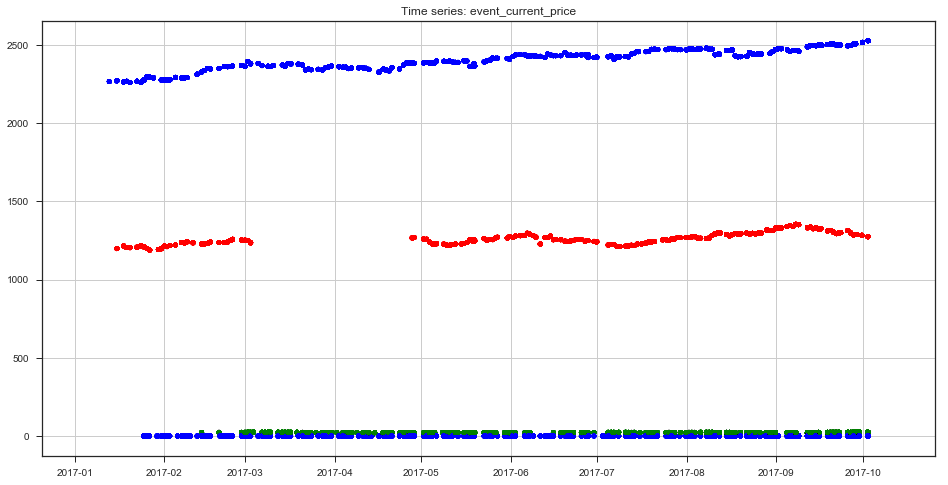

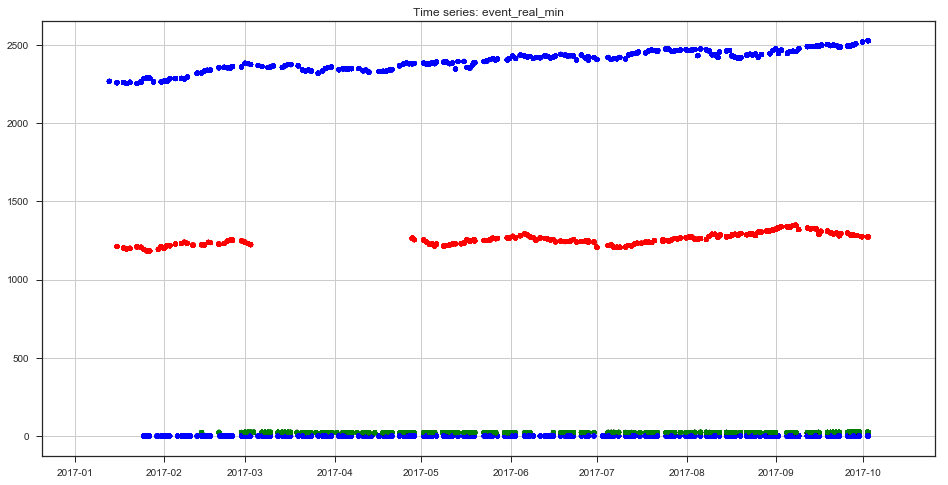

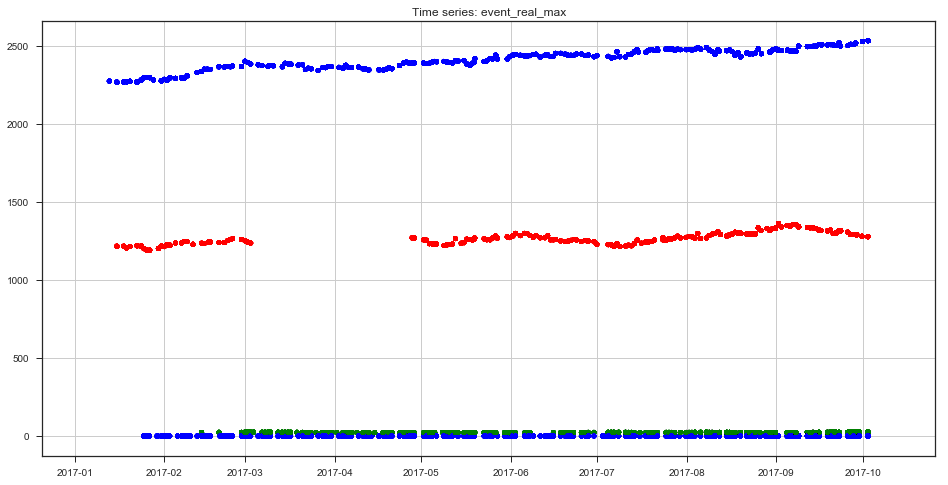

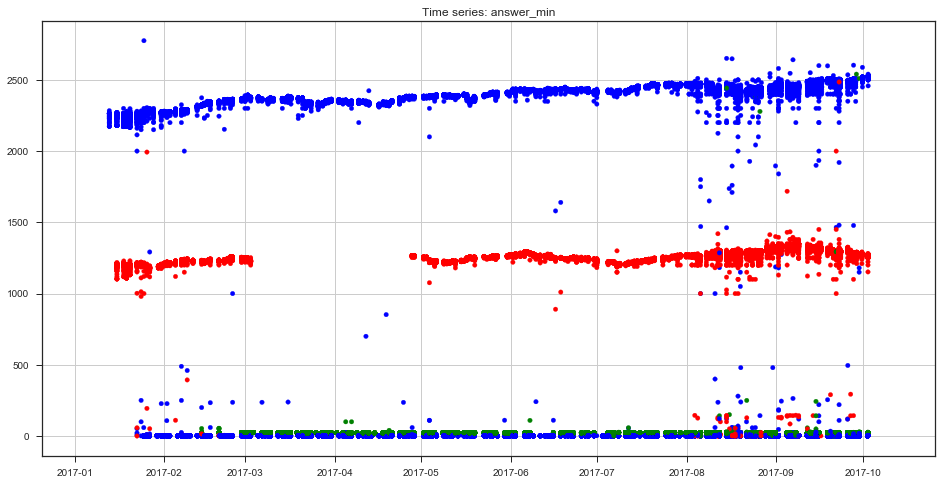

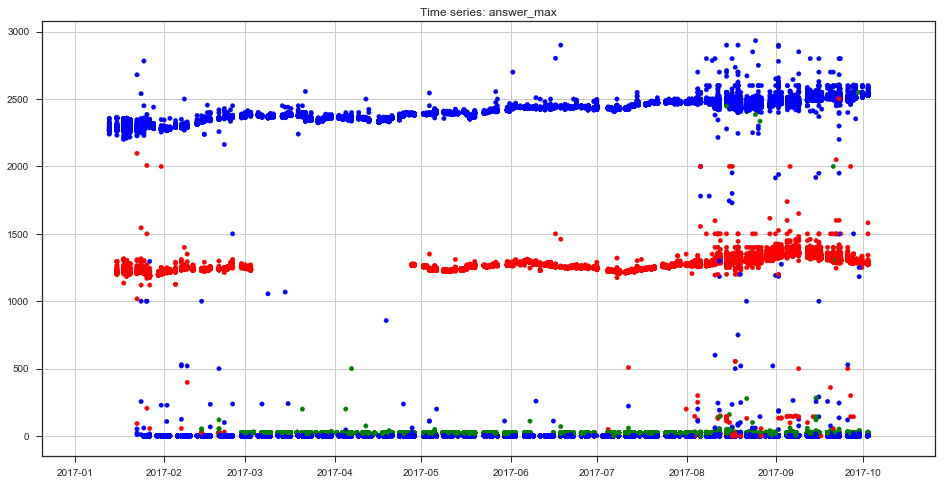

In [129]:
num_features = ['event_current_price','event_real_min','event_real_max', 'answer_min', 'answer_max']

for feature in num_features:
    fig = plt.figure(figsize=(16,8))
    ax  = fig.add_subplot(111)
    plt.title('Time series: '+ str(feature))
    ax.scatter(data_ts.index, data_ts[feature], s=20, c=color)
    #ax.scatter(data_ts.index, data_ts['answer_max'], s=20, c='r')
    plt.grid(True)
    #plt.legend(loc='best')
    plt.show()

Each ticker has it's level of price which can variate in a small interval. Knowing the ticker and the event_current_price users can forecast quite well the min and max.We can also notice that at the end user forecasts become more dispersed.

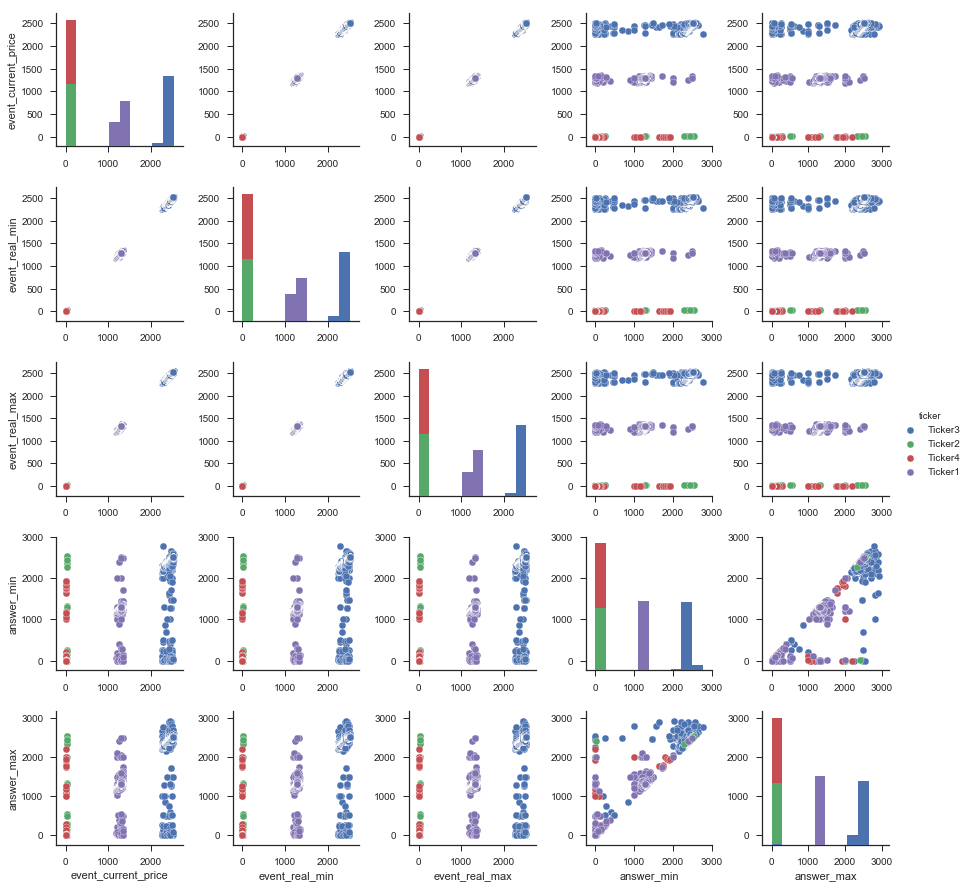

In [64]:
# Pairplot numerical features
num_features = ['event_current_price','event_real_min','event_real_max', 'answer_min', 'answer_max','ticker']
#sns.set(style="ticks")
# Draw a pairplot with the numeric values in each cell
#f, ax = plt.subplots(figsize=(9, 6))
sns_plot = sns.pairplot(data_na[num_features], hue='ticker')
plt.show()

We see that even if the ticker is known but answer for the given event can variate largely from 0 up to 2400. (Here we are not taking into account aberrant responses like 240000 or 99999)

In [82]:
# Histogramm to estimate if 
    # the answers min/ max distribution are close to real min/ max
    # for each ticker
    
num_features = ['event_current_price','event_real_min','event_real_max', 'answer_min', 'answer_max']
# Scale numerical features
data_sc = StandardScaler().fit_transform(data_na[num_features])
data_sc = pd.DataFrame(data_sc, columns = num_features)
data_sc['ticker'] = data_na['ticker']
data_sc.head()

,event_current_price,event_real_min,event_real_max,answer_min,answer_max,ticker
0,1.328671,1.329523,1.330779,1.339679,1.326311,Ticker3
1,1.328671,1.329523,1.330779,1.333028,1.337355,Ticker3
2,1.328671,1.329523,1.330779,1.316916,1.347418,Ticker3
3,1.328671,1.329523,1.330779,1.328792,1.327783,Ticker3
4,1.328671,1.329523,1.330779,1.326813,1.318947,Ticker3


Let's now look at the histogramme of responses and real values on each bound.

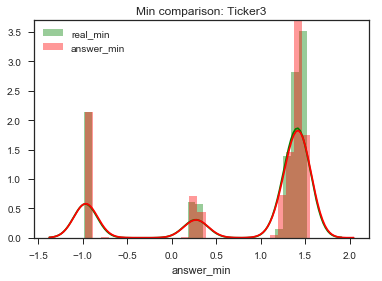

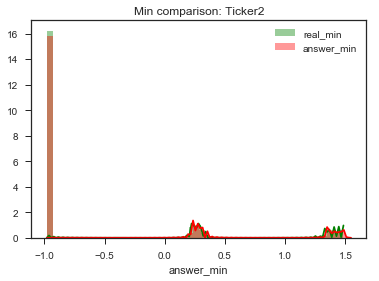

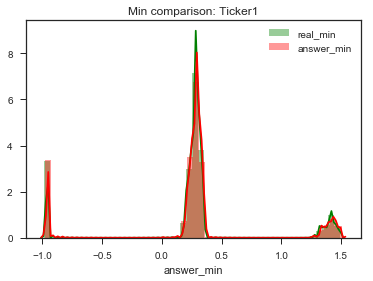

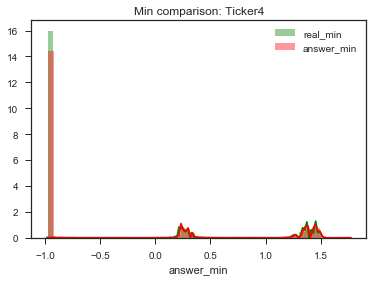

In [87]:
#f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)

for ticker in list(set(data_na['ticker'])):
    #plt.figure()
    plt.title('Min comparison: ' + str(ticker))
    sns.distplot(data_sc[data_sc['ticker']==ticker]['event_real_min'],color="g")
    sns.distplot(data_sc[data_sc['ticker']==ticker]['answer_min'],color="r")
    plt.legend(('real_min','answer_min'))
    #plt.setp(axes, yticks=[])
    #plt.tight_layout()
    plt.show()

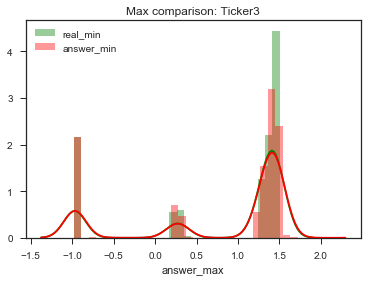

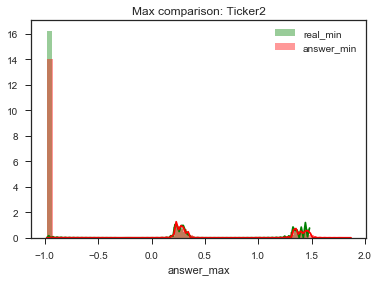

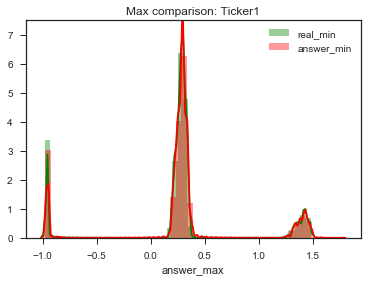

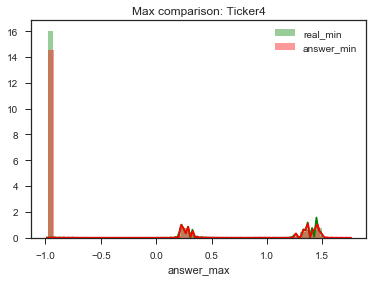

In [88]:
for ticker in list(set(data_na['ticker'])):
    #plt.figure()
    plt.title('Max comparison: ' + str(ticker))
    sns.distplot(data_sc[data_sc['ticker']==ticker]['event_real_max'],color="g")
    sns.distplot(data_sc[data_sc['ticker']==ticker]['answer_max'],color="r")
    plt.legend(('real_min','answer_min'))
    #plt.setp(axes, yticks=[])
    #plt.tight_layout()
    plt.show()

# Feature engineering

In [131]:
print(data.dtypes)
print(data.shape)

user_id                        object
user_created_at        datetime64[ns]
event_id                       object
event_created_at       datetime64[ns]
event_end_time         datetime64[ns]
ticker                         object
event_current_price           float64
event_real_min                float64
event_real_max                float64
answer_created_at      datetime64[ns]
answer_min                    float64
answer_max                    float64
dtype: object
(61765, 12)


Let's create additional features and see if they can help us in regression problem:
- "user_exp" - Number of events made by the given user. May be the analogue of experience;
- "dif" - Relative time between the user answer_created_at date and event_end_time. May be that the response which are made closer to the end could be closer to the real value as well. This will replace 'answer_created_at' and 'event_end_time' columns.
- "error_min" - the error between event_real_min and answer_min. This will replace 'answer_min' columns.
- "error_max" - the error between event_real_max and answer_max. This will replace 'answer_max' columns.

In [137]:
df = data.copy(deep=True)

In [144]:
experience = df.groupby('user_id')['event_id'].count()
df['user_exp'] = df['user_id'].map(experience)
df['error_min'] = df['event_real_min'] - df['answer_min']
df['error_max'] = df['event_real_max'] - df['answer_max']

In [149]:
# get time difference between dates
df['dif'] = df['event_end_time'] - df['answer_created_at']

In [151]:
df['dif'] = df['dif'].apply(lambda x: x.total_seconds())

In [152]:
df['dif'].head()

0     36.822344
1     83.280278
2    738.499851
3    362.698734
4    657.753211
Name: dif, dtype: float64

In [136]:
experience.head()

user_id
00031299-dc76-4c41-b6f8-9498a18f563a    1
001771ed-30dc-4738-bbe5-b8c4c71735e3    4
004a7acb-72ac-43ad-8843-eb7c974fddef    2
006e9404-46a6-43d4-b365-b8c54640a1fe    3
00cfe575-8b63-4b34-995b-4af61779e2ff    2
Name: event_id, dtype: int64

In [153]:
df.columns

Index(['user_id', 'user_created_at', 'event_id', 'event_created_at',
       'event_end_time', 'ticker', 'event_current_price', 'event_real_min',
       'event_real_max', 'answer_created_at', 'answer_min', 'answer_max',
       'user_exp', 'error_min', 'error_max', 'dif'],
      dtype='object')

In [ ]:
# This time we will take all the rows (including abherent answers data)
features = ['event_current_price','event_real_min','event_real_max', 'answer_min', 'answer_max','ticker']

### Encoding of categorical variables

As we have just one categorical column we can simply use OneHotEncoding to deal with it

In [160]:
# encode 'ticker' column
df_cat = pd.get_dummies(df['ticker'].astype(str))

In [164]:
# Concatenate with df and drop previous 'ticker' column
df[df_cat.columns] = df_cat

In [166]:
df.drop('ticker', axis=1, inplace=True)
df.head()

,user_id,user_created_at,event_id,event_created_at,event_end_time,event_current_price,event_real_min,event_real_max,answer_created_at,answer_min,answer_max,user_exp,error_min,error_max,dif,Ticker1,Ticker2,Ticker3,Ticker4
0,5ada43ce-5f15-4e51-8315-4f04f5c432d1,2017-01-20 06:50:27.018157,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,2344.75,2338.25,2356.0,2017-03-23 13:24:23.177656,2341.00,2348.50,528,-2.75,7.50,36.822344,0,0,1,0
1,a2129dbe-827f-4b1b-b3aa-ab9940848416,2016-06-15 13:27:52.295767,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,2344.75,2338.25,2356.0,2017-03-23 13:23:36.719722,2334.28,2359.75,335,3.97,-3.75,83.280278,0,0,1,0
2,b0e198cc-55f4-4c8e-9209-5553dff80f76,2016-05-31 10:09:47.230857,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,2344.75,2338.25,2356.0,2017-03-23 13:12:41.500149,2318.00,2370.00,231,20.25,-14.00,738.499851,0,0,1,0
3,6fb01a2d-12e7-4809-a966-ce7ad76d99b2,2017-01-11 13:45:25.814684,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,2344.75,2338.25,2356.0,2017-03-23 13:18:57.301266,2330.00,2350.00,184,8.25,6.00,362.698734,0,0,1,0
4,351cc531-29c3-4c87-ba1d-4b2e87be5ee4,2016-10-06 18:45:12.953110,61a5e5d2-f4bd-4829-9527-331dd3bedf27,2017-03-22 20:38:00.476338,2017-03-23 13:25:00,2344.75,2338.25,2356.0,2017-03-23 13:14:02.246789,2328.00,2341.00,505,10.25,15.00,657.753211,0,0,1,0


# Prediction part
### Work with event_real_min as target

In [168]:
# split data into test and train
features = ['event_current_price','user_exp','error_min','error_max','dif','Ticker1','Ticker2','Ticker3','Ticker4']
Xtrain, Xtest, ytrain, ytest = train_test_split(df[features], df['event_real_min'], test_size=0.2, random_state=42)
print('Training Features shape: ', Xtrain.shape)
print('Testing Features shape: ', Xtest.shape)

Training Features shape:  (49412, 9)
Testing Features shape:  (12353, 9)


In [169]:
# Random Forest with default hyper-parameters
regr = RandomForestRegressor(bootstrap = True, max_depth = 4, max_features = 8, min_samples_leaf = 4,
                                   min_samples_split = 4, n_estimators = 1000)
regr.fit(Xtrain, ytrain)
# predict
preds = regr.predict(Xtest)

MSE:  121.76405809621141


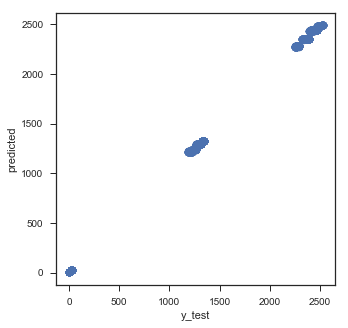

In [192]:
model_perfo(ytest, preds)

Preds and real values are alligned quite well on the diagonal line. In the ideal case when predicted values are equal to y_test all the points need to be on the 45deg line. Now let's try to improve it by tuning the hyper-parameters of our Regressor. 

In [176]:
# Random Forest after grid-search
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 50],
    #'max_features': ['auto', 'sqrt'],
    #'max_features': [ 4, 6, 8, 10],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [4, 5],
    'n_estimators': [100, 500]
}
grid_search = GridSearchCV(estimator = regr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(Xtrain, ytrain)
# predict
preds_grid = grid_search.predict(Xtest)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 16.1min finished


MSE:  3.498153961461217


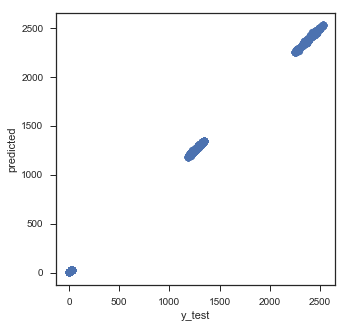

In [191]:
model_perfo(ytest, preds_grid)

After tuning the MSE has been reduced almost 40 times with respect to the previous model. 

### Work with event_real_max as target
As the target variable has the same nature as event_real_max we will also  use RFR model with tuning of hyper-parameters as well.

In [183]:
# split data into test and train
features = ['event_current_price','user_exp','error_min','error_max','dif','Ticker1','Ticker2','Ticker3','Ticker4']
Xtrain_max, Xtest_max, ytrain_max, ytest_max = train_test_split(df[features], df['event_real_max'], test_size=0.2, random_state=42)
print('Training Features shape: ', Xtrain_max.shape)
print('Testing Features shape: ', Xtest_max.shape)

Training Features shape:  (49412, 9)
Testing Features shape:  (12353, 9)


In [184]:
grid_search = GridSearchCV(estimator = regr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(Xtrain_max, ytrain_max)
# predict
preds_grid_max = grid_search.predict(Xtest_max)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 16.8min finished


MSE:  3.6166712500354907


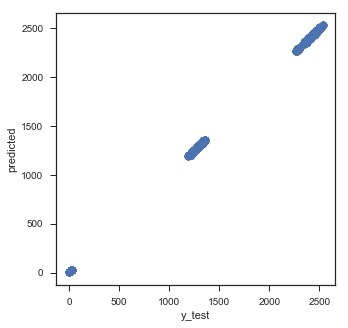

In [190]:
model_perfo(ytest_max, preds_grid_max)

For the case of event_real_max MSE=3.62 is of the same order as for event_real_min.

# Conclusion

To enhance the prediction performance we can try to use SupportVectorRegressor with non-linear kernel of 'rbf' type which is havier computational resources required but can reduce MSE. 

Another possibility is to use the pipeline of 2 regressors: RFR will serve to select best features and the second one like AdaBoostRegressor or XGBoost Regressor  can do the prediction on already selected features. But in this case we need to be careful with overfitting when choosing the model of high degree with too much parameters to regulate.

Another opportunity that we can use in the case of big number of features or when it's not evident which of new columns to create we can try to use Polinomial Features creation from the existing ones and then select the most important columns.